In [44]:
import importlib
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

import financial_data_structs as fds
# adding parent dir to path
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(''))))
import adv_fin_ml_func as fml

%matplotlib inline
importlib.reload(sys.modules['adv_fin_ml_func'])

<module 'adv_fin_ml_func' from '/mnt/c/Users/mlevy/Workspace/Advances-in-Financial-Machine-Learning/F-ML/adv_fin_ml_func.py'>

### 3.1
On dollar bars, apply a symmetric CUSUM filter (where the threshold is the standard deviation of daily returns), add vertical bars, apply the triple-barrier method, and apply getBins to generate labels

In [2]:
out_fp = '../../data/clean/IVE_tick.parq'
df = fds.parquet_to_df(out_fp)
df.head()

,price,bid,ask,volume,dollar_volume
timestamp,,,,,
2009-09-28 09:30:00,50.79,50.70,50.79,100,5079.00
2009-09-28 09:30:00,50.71,50.70,50.79,638,32352.98
2009-09-28 09:31:32,50.75,50.75,50.76,100,5075.00
2009-09-28 09:31:33,50.75,50.72,50.75,100,5075.00
2009-09-28 09:31:50,50.75,50.73,50.76,300,15225.00


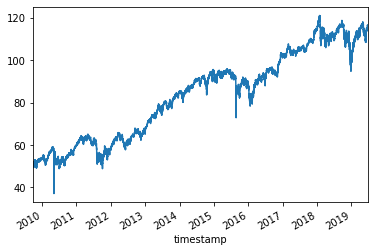

In [3]:
df_dol = fds.get_dollar_bars(df, 1_000_000)
df_dol.price.plot()

In [4]:
close = df_dol.price.copy()

# Remove duplicate indexes
close = close[~close.index.duplicated()]

In [5]:
# getting standard deviation of daily returns
dailyVol = fml.getDailyVol(close)

In [6]:
dailyVol.head()

timestamp
2009-09-29 09:59:21         NaN
2009-09-29 10:04:46    0.005981
2009-09-29 10:31:39    0.004469
2009-09-29 10:52:23    0.004376
2009-09-29 11:34:53    0.004261
Name: price, dtype: float64

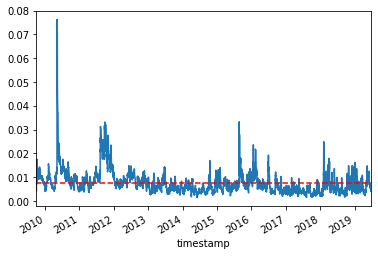

In [8]:
f, ax = plt.subplots()
dailyVol.plot(ax=ax)
ax.axhline(dailyVol.mean(), ls='--', color='r')

In [11]:
# CUSUM Filter
tEvents = fml.getTEvents(close, h=dailyVol.mean())

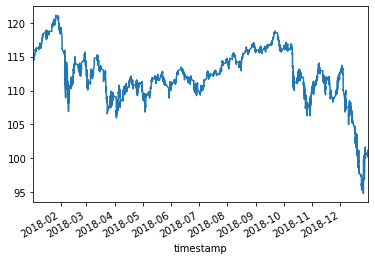

In [13]:
df_dol['2018'].price.plot()

In [15]:
tEvents.plot()

AttributeError: 'DatetimeIndex' object has no attribute 'plot'

AttributeError: 'DatetimeIndex' object has no attribute 'plot'

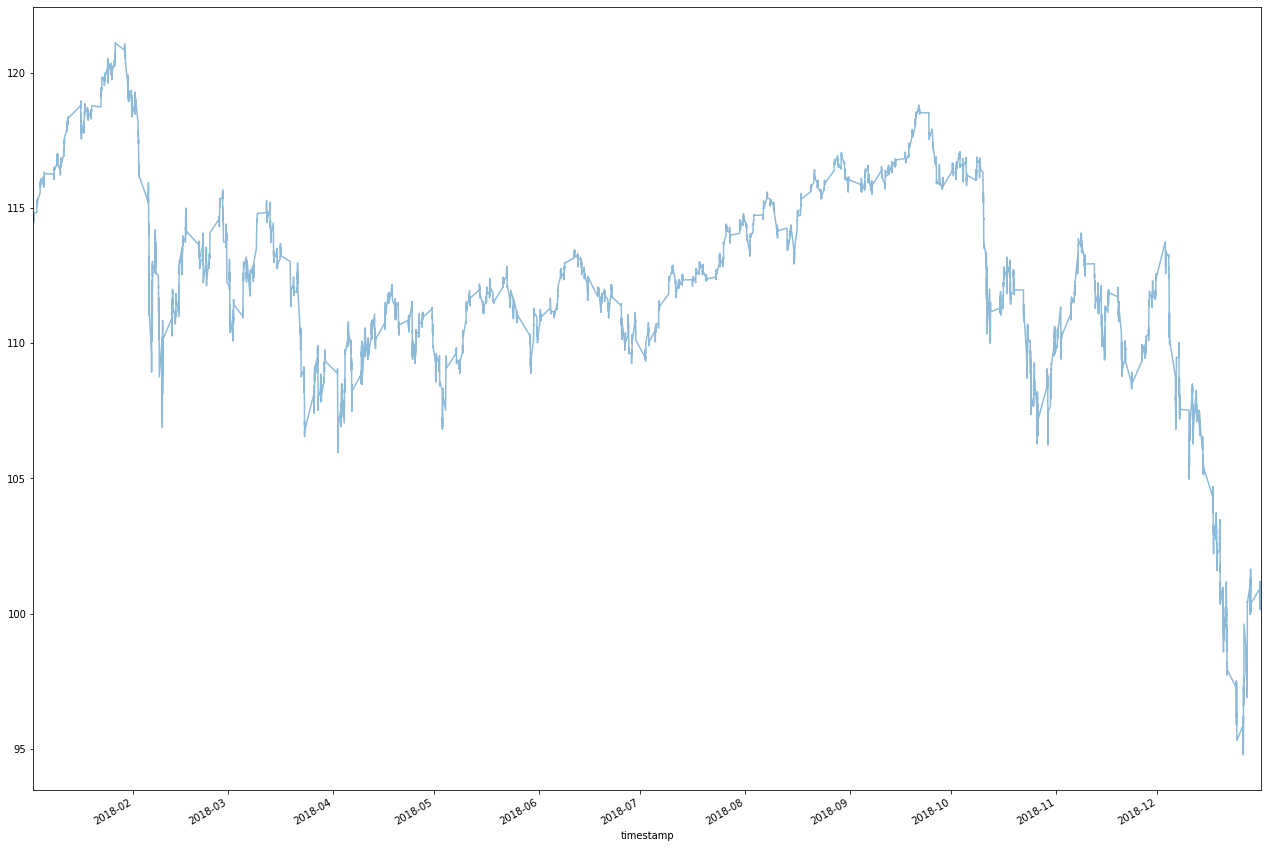

In [16]:
f, ax = plt.subplots(figsize=(22,16))
df_dol['2018'].price.plot(ax=ax, alpha=.5)
tEvents.plot(ax=ax,ls='',marker='^', markersize=10,
                     alpha=0.75, label='upcross', color='g')

In [19]:
tEvents

DatetimeIndex(['2009-09-28 09:53:49', '2009-09-28 10:02:52',
               '2009-09-28 10:10:21', '2009-09-28 10:19:36',
               '2009-09-28 10:24:23', '2009-09-28 10:34:30',
               '2009-09-28 10:45:25', '2009-09-28 11:10:57',
               '2009-09-28 11:24:29', '2009-09-28 11:37:06',
               ...
               '2019-06-25 13:26:19', '2019-06-25 13:53:59',
               '2019-06-25 14:05:49', '2019-06-25 14:40:37',
               '2019-06-25 14:52:53', '2019-06-25 15:26:58',
               '2019-06-25 15:45:56', '2019-06-25 15:50:57',
               '2019-06-25 15:55:00', '2019-06-25 15:59:23'],
              dtype='datetime64[ns]', length=54200, freq=None)

In [29]:
df_dol['2009-09-28 09:53']

,price,bid,ask,volume,dollar_volume
timestamp,,,,,
2009-09-28 09:53:49,51.14,51.13,51.14,2000,102280.0


In [30]:
df_dol['2009-09-28 09:53:49']

KeyError: '2009-09-28 09:53:49'

In [31]:
# todo why doesnt the above work? I'd like to plot df_dol['2018'] w/ tEvents dots like pg 40

In [33]:
# Adding Vertical bars
# This is the expiration limit in our triple barrier method
t1 = fml.addVerticalBarrier(tEvents, close, numDays=1)

In [34]:
t1

2009-09-28 09:53:49   2009-09-29 09:59:21
2009-09-28 10:02:52   2009-09-29 10:04:46
2009-09-28 10:10:21   2009-09-29 10:31:39
2009-09-28 10:19:36   2009-09-29 10:31:39
2009-09-28 10:24:23   2009-09-29 10:31:39
                              ...        
2019-06-24 14:12:36   2019-06-25 14:40:37
2019-06-24 14:53:26   2019-06-25 15:26:58
2019-06-24 15:31:29   2019-06-25 15:45:56
2019-06-24 15:38:51   2019-06-25 15:45:56
2019-06-24 15:55:00   2019-06-25 15:55:00
Name: timestamp, Length: 54178, dtype: datetime64[ns]

In [45]:
# Applying triple-barrier method
minRet = 0.02
numThreads = 1
ptSl = [1, 1]
events = fml.getEvents(close, tEvents, ptSl, dailyVol, minRet, numThreads, t1=t1)